# MRI-3T-taskfMRI

**Overview**

In this notebook, we will analyze the episodic encoding-retrieval task. 

Section 0) A full walkthrough of one subject analysis, and then looping over subjects, 2) Plotting group-level data and significance testing, 3) Applying the same to the neocortex instead of hippocampus,

These steps are then repeated for the encoding phase, contrasting trials which would be subsequently remembered vs. those subsequently forgotten.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import hippomaps as hm
import pandas as pd
import nilearn
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import run_glm
from nilearn.glm.contrasts import compute_contrast
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.utils.parcellation import map_to_labels
import pickle
from scipy.stats import ttest_1samp
import warnings
warnings.filterwarnings("ignore")
import time
start_time = time.time()

In [67]:
# config

useCheckpoints = True # this will download and use checkpoint numpy array data instead of mapping local data to hippocampal surfaces 
if useCheckpoints:
    hm.fetcher.get_tutorialCheckpoints(['MRI-3T-taskfMRI_samplesubject-episodic.npz'])
    hm.fetcher.get_tutorialCheckpoints(['MRI-3T-taskfMRI_betas-retrieval.npz'])
    hm.fetcher.get_tutorialCheckpoints(['MRI-3T-taskfMRI_betas-encoding.npz'])
    
# locate input data
ses = '01'
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0'
micapipe_raw = '/data/mica3/BIDS_MICs/rawdata/' # this we need for the events.tsv files
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'

# define which subjects and surfaces to examine
subs = [
 'HC001', 'HC002', 'HC005', 'HC006', 'HC007', 'HC011', 'HC012', 'HC013', 'HC014', 'HC015',
 'HC016', 'HC017', 'HC018', 'HC019', 'HC020', 'HC021', 'HC022', 'HC023', 'HC025', 'HC026',
 'HC027', 'HC028', 'HC029', 'HC030', 'HC031', 'HC032', 'HC033', 'HC034', 'HC035', 'HC036', 
 'HC037', 'HC038', 'HC039', 'HC040', 'HC041', 'HC042', 'HC043', 'HC044', 'HC045', 'HC046', 
 'HC047', 'HC048', 'HC049', 'HC050', 'HC051', 'HC052', 'HC053', 'HC054', 'HC055', 'HC056', 
 'HC057', 'HC058', 'HC059', 'HC060', 'HC061', 'HC063', 'HC065', 'HC067', 'HC068', 'HC069', 
 'HC070', 'HC071', 'HC072', 'HC074', 'HC075', 'HC077', 'HC078', 'HC081', 'HC082', 'HC084', 
 'HC086', 'HC087', 'HC088', 'HC089', 'HC090', 'HC093', 'HC097', 'HC100', 'HC024', 'HC064', 
 'HC073', 'HC101']
hemis = ['L','R']
labels = ['hipp']# ,'dentate'] 
den='2mm'
sigma = 1 # Gaussian smoothing kernal sigma (mm) to apply to surface data
TR = 0.6 # repetition time (seconds)
tasks= ['encoding','retrieval']
slice_time_ref = 0.0
nVolumes=850 # Max timeseries length (will be padded with NaNs if the run is shorter)
tmp_dir = 'tmp_fMRI_3T'

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# 3. Load neocortical surfaces for visualzation
parcL, parcR = load_parcellation('schaefer')
parc = np.concatenate((parcL, parcR))
nP = len(np.unique(parcL))-1 # number of neocortical parcels (one hemisphere)
c69_inf_lh, c69_inf_rh = load_conte69()

## 0) single subject walkthrough

In [68]:
s=0
sub = subs[s]

## 0.1) Map data to hippocampal surface (single subject example)

In this example, we loop through subjects and hemispheres, and sample volumetric timeseries data onto hippocampal surfaces. We then apply smoothing. Finally, we save the data from all surfaces into `.func.gii` files.

Note that here we run only one subject, but all subjects can easily be enumerated!

In [69]:
if not useCheckpoints:
    !mkdir -p {tmp_dir}

    cdata_hipp = np.ones((nV,len(hemis),nVolumes,len(tasks),1))*np.nan
    neo_ts = np.ones((nP,len(hemis),nVolumes,len(tasks),1))*np.nan
    all_events = np.empty((len(tasks),1),dtype=object)
    all_motion_reg = np.empty((len(tasks),1),dtype=object)

    for t,task in enumerate(tasks):

        # events and regressors
        all_events[t,s] = pd.read_table(f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_events.tsv')
        all_motion_reg[t,s] = np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-{task}_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se.1D')

        # convert affines 
        cmd1a = f'/data_/mica1/01_programs/c3d-1.0.0-Linux-x86_64/bin/c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-se_task-{task}_acq-AP_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
        !{cmd1a}
        cmd1b = f'/data_/mica1/01_programs/c3d-1.0.0-Linux-x86_64/bin/c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-{task}_acq-AP_bold_mode-image_desc-SyN_0GenericAffine.mat '\
            f'-inv '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
        !{cmd1b}
        
        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                #apply affines
                cmd2a = f'wb_command -surface-apply-affine '\
                    f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'
                !{cmd2a}
                cmd2b = f'wb_command -surface-apply-affine '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                !{cmd2b}
                # apply warp (Note this is actually the INVERSE warp)
                cmd3 = f'wb_command -surface-apply-warpfield '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-{task}_acq-AP_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                !{cmd3}

                # sample
                cmd4 = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-{task}_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                    f'-enclosing'
                !{cmd4}

                # smooth
                cmd5 = f'wb_command -metric-smoothing '\
                    f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                    f'{sigma} '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii '
                !{cmd5}

                # load mapped hippocmapal surface data
                func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii')
                for k in range(len(func.darrays)):
                    cdata_hipp[iV[l],h,k,t,s] = func.darrays[k].data

                # Load the neocortical timeseries in fsLR32k and dowmsample to schaefer 400 space
                func = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-{task}_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
                func_parc = np.ones((int(nP*2),nVolumes))*np.nan
                for i in range(int(nP*2)):
                    for k in range(func.shape[0]):
                        func_parc[i,k] = np.nanmean(func[k, parc == (i + 1)])
                neo_ts[:,:,:,t,s] = func_parc.reshape((nP,2,nVolumes))

    np.savez_compressed("../checkpoints/MRI-3T-taskfMRI_samplesubject-episodic", cdata_hipp, neo_ts, all_events, all_motion_reg)
    !rm -r {tmp_dir}

In [70]:
loaddat = np.load("../checkpoints/MRI-3T-taskfMRI_samplesubject-episodic.npz", allow_pickle=True)
hipp_ts = loaddat['arr_0']
neo_ts = loaddat['arr_1']
all_events = loaddat['arr_2']
all_motion_reg = loaddat['arr_3']

In [71]:
all_events.shape

(2, 1)

## 0.2) create design matrix for retrieval condition

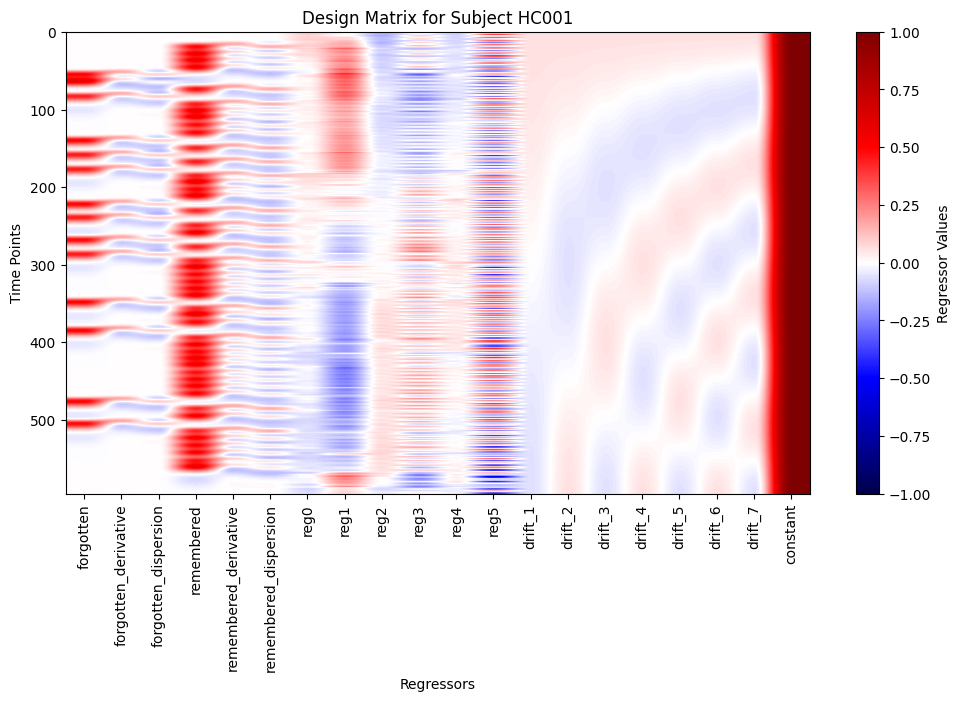

In [73]:
nContrasts = 2
conditions = ['remembered', 'forgotten']

contrasts_epiretrieve = np.ones((nV, len(hemis),1,nContrasts))*np.nan 
contrasts_epiretrieve_neo = np.ones((nP, len(hemis),1,nContrasts)) * np.nan

t = 1 # second task


# Specify the timing of fmri frames 
motion_reg = all_motion_reg[t,s]
frame_times = TR * (np.arange(motion_reg.shape[0]) + slice_time_ref)
events = all_events[t,s]
# Recode events to include fixation, stimulus, key press/response to soak up variance
df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time','subject_response','prime','target']]
df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'}, inplace=True)
df['trial_type']=None
df['trial_type'] = df.apply(lambda row: 'remembered' if row['target'] == row['subject_response'] else 'forgotten', axis=1)



design_matrix = make_first_level_design_matrix(frame_times,
                                            events=df,
                                            hrf_model='spm + derivative + dispersion',
                                            add_regs=motion_reg
                                            )
# in case of some trial types missing, add extras with all 0sL
for condition in conditions:
    if condition not in design_matrix.columns:
        # Create columns for condition, its derivatives, and dispersion
        design_matrix[condition] = 0
        design_matrix[f'{condition}_derivative'] = 0
        design_matrix[f'{condition}_dispersion'] = 0    

# plot design matrix
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

## 0.3) create design matrix for retrieval condition

In [74]:
### define contrasts of interest ###

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
            for i, column in enumerate(design_matrix.columns)])

contrasts = {
'retrieval_uncorrected': (
    basic_contrasts['remembered']
    + basic_contrasts['remembered_derivative']
    + basic_contrasts['remembered_dispersion']),
'retrieval_corrected': (
    basic_contrasts['remembered']
    - basic_contrasts['forgotten']
    + basic_contrasts['remembered_derivative']
    - basic_contrasts['forgotten_derivative']
    + basic_contrasts['remembered_dispersion']
    + basic_contrasts['forgotten_dispersion'])}

contrasts

{'retrieval_uncorrected': array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'retrieval_corrected': array([-1., -1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.])}

## 0.4) fit the timeseries

In [76]:
contrasts_epiretrieve = np.ones((nV, len(hemis), 1, nContrasts))*np.nan # 6 different contrasts will be considered
contrasts_epiretrieve_neo = np.ones((nP, len(hemis), 1, nContrasts)) * np.nan

for h, hemi in enumerate(hemis):

    ### fit the design matrix to the data
    labels_, estimates = run_glm(cdata_hipp[:,h,:210,t,s].T, design_matrix.values[:210]) # the last part of the task block is simply rest, so we will cut it
    labels_neo, estimates_neo = run_glm(neo_ts[:,h,:210,t,s].T, design_matrix.values[:210]) # the last part of the task block is simply rest, so we will cut it

    ### run contrasts of interest
    for c, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        # Compute contrast-related statistics
        contrast = compute_contrast(labels_, estimates, contrast_val, contrast_type='t')
        contrasts_epiretrieve[:, h, s, c] = contrast.z_score()
        contrast = compute_contrast(labels_neo, estimates_neo, contrast_val, contrast_type='t')
        contrasts_epiretrieve_neo[:, h, s, c] = contrast.z_score()

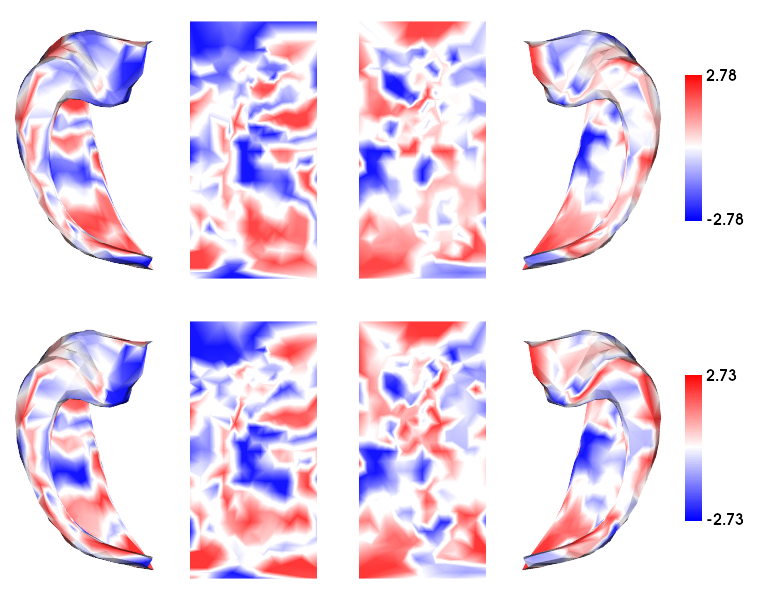

In [77]:
# plot each contrast
hm.plotting.surfplot_canonical_foldunfold(contrasts_epiretrieve, den='2mm', hemis=hemis, labels=labels, tighten_cwindow=True, unfoldAPrescale=True, cmap='bwr', color_range='sym', share='row', color_bar='right', embed_nb=True)

## 2) Episodic Retrieval for ALL subjects

In [78]:
if not useCheckpoints:
    contrastnames_patternsep2=list(contrasts.keys())
    contrasts_epiretrieve = np.ones((nV, 2, len(subs), len(contrastnames_patternsep2))) * np.nan
    contrasts_epiretrieve_neo = np.ones((200, 2, len(subs), len(contrastnames_patternsep2))) * np.nan
    for s, sub in enumerate(subs):
        for h, hemi in enumerate(hemis):
            for l, label in enumerate(labels):
                for c, contrast_name in enumerate(contrastnames_patternsep2):                 
                    contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/retrieval/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-retrieval_contrast-{contrast_name}.shape.gii'
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_epiretrieve[:, h, s, c] = data
                    contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/retrieval/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-retrieval_contrast-{contrast_name}.shape.gii'
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_epiretrieve_neo[:,h, s, c] = data  # Corrected indexing
    np.savez_compressed("../checkpoints/MRI-3T-taskfMRI_betas-retrieval", contrasts_epiretrieve, contrasts_epiretrieve_neo)

In [80]:
loaddat = np.load("../checkpoints/MRI-3T-taskfMRI_betas-retrieval.npz", allow_pickle=True)
contrasts_epiretrieve = loaddat['arr_0']
contrasts_epiretrieve_neo = loaddat['arr_1']

## 2.1) Group-averaging 

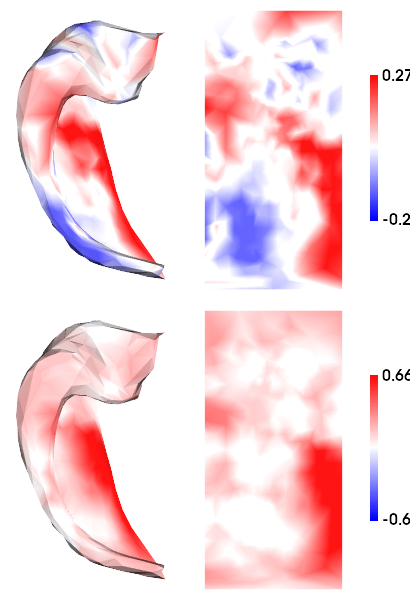

In [81]:
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_epiretrieve,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, cmap='bwr', color_range='sym', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

## 2.2) Significance/consistency testing

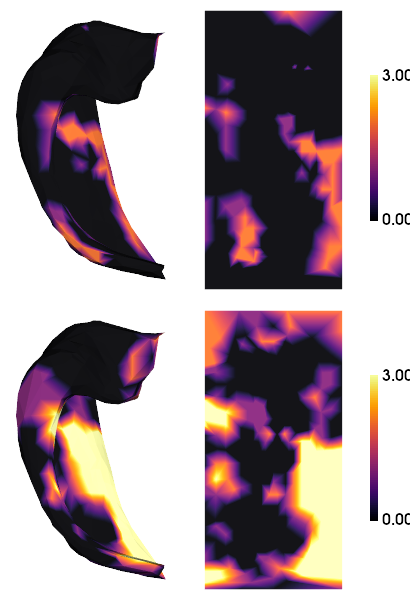

In [82]:
t = ttest_1samp(contrasts_epiretrieve.reshape((nV,2*len(subs),nContrasts)),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [83]:
#save the average maps
!mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-MICs
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for c,contrastname_epiretrieve in enumerate(list(contrasts.keys())):
            cdat = np.nanmean(contrasts_epiretrieve[iV[l],h,:,c],axis=1).flatten().astype(np.float32) 
            data_array = nib.gifti.GiftiDataArray(data=cdat.astype(np.float32))
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-epiretrieve_average-{len(subs)}_hemi-{hemi}_den-2mm_label-{label}_contrast-{contrastname_epiretrieve}.shape.gii')

TtestResult(statistic=5.644674339332291, pvalue=1.793990500400226e-08, df=3320)
TtestResult(statistic=12.768623739267717, pvalue=1.7465780338207096e-36, df=3320)
TtestResult(statistic=5.740972166418419, pvalue=1.0260276013972215e-08, df=3320)
TtestResult(statistic=11.723977024544128, pvalue=3.9138928774475073e-31, df=3320)


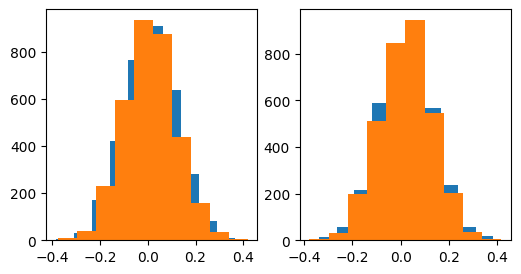

In [84]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,nContrasts))
fig, ax = plt.subplots(nrows=1, ncols=nContrasts, figsize=(3*nContrasts,3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(list(contrasts.keys())):
        cdat = contrasts_epiretrieve[:,h,:,f].reshape((nV,-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        print(ttest_1samp(fcorr,0,nan_policy='omit'))
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

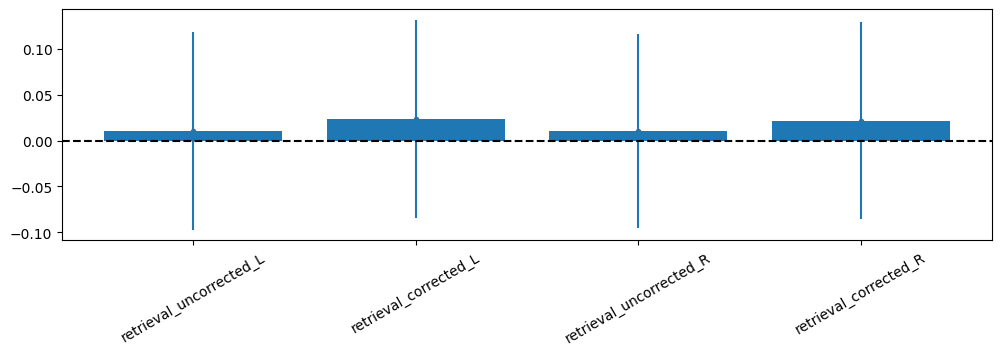

In [85]:
xnames = [s + "_L" for s in list(contrasts.keys())] + [s + "_R" for s in list(contrasts.keys())]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

## 2.3) Consider the neocortex

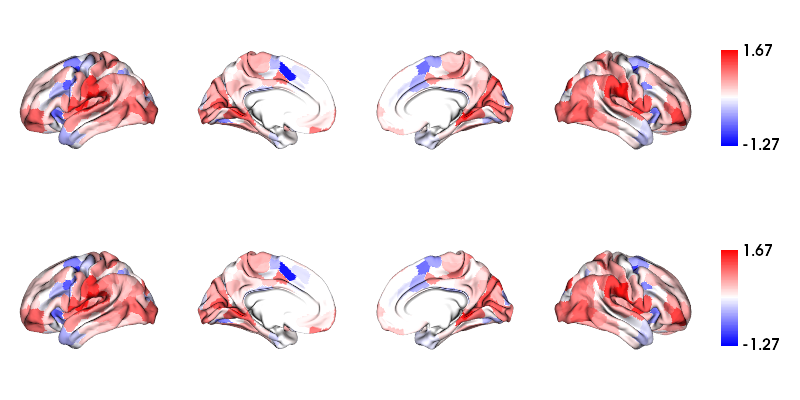

In [86]:
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points, nContrasts])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(nP):
        for c, contrast_name in enumerate(list(contrasts.keys())): 
            mc[parc==(i+1+(h*nP))] = np.nanmean(contrasts_epiretrieve_neo,axis=2)[i,h,c]
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,len(list(contrasts.keys()))), 
                 size=(800,200*len(list(contrasts.keys()))), color_bar=True, cmap='bwr', embed_nb=True,nan_color=(1, 1, 1, 1))

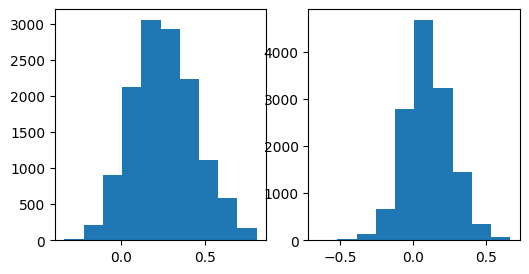

In [87]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,len(list(contrasts.keys()))))
fig, ax = plt.subplots(nrows=1, ncols=len(list(contrasts.keys())), figsize=(3*len(list(contrasts.keys())),3))
for f,feature in enumerate(list(contrasts.keys())):
    cdat = contrasts_epiretrieve_neo[:,:,:,f].reshape((nP,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

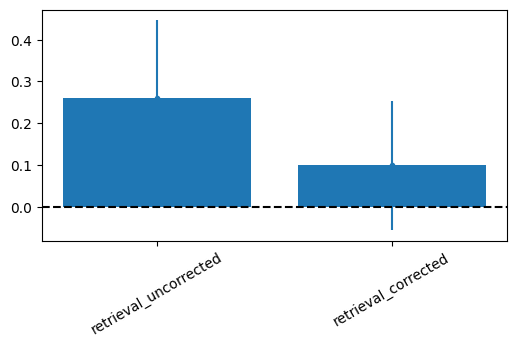

In [88]:
xnames = list(contrasts.keys())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(list(contrasts.keys())),3))
plt.bar(range(len(list(contrasts.keys()))),mfcorr)
plt.errorbar(range(len(list(contrasts.keys()))),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(list(contrasts.keys()))),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

## 3) Episodic encoding -subsequent memory 

## 3.1) GLM fit
Again, this section is very similar to the above, but with different input data, conditions, and contrasts. We also don't walk through one subject, but rather run all subjects together

In [89]:
s=0 # run only one subject as a sample

nContrasts = 2
contrasts_epiencode = np.ones((nV, len(hemis), 1, nContrasts))*np.nan # 2 different contrasts will be considered
contrasts_epiencode_neo = np.ones((nP, len(hemis), 1, nContrasts)) * np.nan

conditions = ['correct', 'incorrect']
current_task='epiencode'
t = 0 # second task

# Specify the timing of fmri frames from one example
motion_reg = all_motion_reg[t,s]
nTRs = motion_reg.shape[0]
frame_times = TR * (np.arange(motion_reg.shape[0]) + slice_time_ref)

### create design matrix ###

# This is slightly more complicated now since we need to look up which stimuli were actually subsequently remmebered by matching their IDs

# Load encoding file
df_encode = all_events[t,s]
df_encode= df_encode[['event_1_onset','event_1_duration','event_2_onset', 'stim_duration','stim_1','stim_2']]
# Recode events to have easy-to-read names
df_encode.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'stim_duration': 'duration'}, inplace=True)
# Load retrieval file
df_retrieve = all_events[1,s]
df_retrieve=df_retrieve[['event_1_onset', 'event_1_duration', 'event_2_onset', 'event_2_duration', 'prime', 'target', 'event_3_onset','subject_response']]
# Recode events to have easy-to-read names
df_retrieve.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur', 'event_2_onset': 'onset', 'event_2_duration': 'duration', 'event_3_onset': 'keypress'}, inplace=True)
df_retrieve['trial_type']=None
df_retrieve['trial_type'] = df_retrieve.apply(lambda row: 'correct' if row['target'] == row['subject_response'] else 'incorrect', axis=1)

new_df = pd.DataFrame(columns=['onset','duration','prime','target','trial_type'])
# Dictionary to keep track of matched rows in df_retrieve
matched_rows_dict = {}

# Iterate through rows in encoding data
i=0
for index, row_encode in df_encode.iterrows():
    stim_1 = row_encode['stim_1']
    stim_2 = row_encode['stim_2']

    # Check if this pair has already been matched
    if (stim_1, stim_2) not in matched_rows_dict:
        # Match rows in retrieval data based on stim_1 and stim_2
        match_rows = df_retrieve[(df_retrieve['prime'] == stim_1) & (df_retrieve['target'] == stim_2)]

        # If there is exactly one match, append the data to the design matrix
        if len(match_rows) == 1:
            matched_row = match_rows.iloc[0]
            new_df.loc[i] = [row_encode['onset'],
                                row_encode['duration'],
                                matched_row['prime'],
                                matched_row['target'],
                                matched_row['trial_type']]
            i+=1

            # Update the matched_rows_dict to mark this pair as matched
            matched_rows_dict[(stim_1, stim_2)] = True
        else:
            # If there is no match or multiple matches, mark this pair as unmatched
            matched_rows_dict[(stim_1, stim_2)] = False

design_matrix = make_first_level_design_matrix(frame_times,
                                    events=new_df,
                                    hrf_model='spm + derivative + dispersion',
                                    add_regs=motion_reg)
for condition in conditions:
    if condition not in design_matrix.columns:
        design_matrix[condition] = 0
        design_matrix[f'{condition}_derivative'] = 0
        design_matrix[f'{condition}_dispersion'] = 0
        
### define contrasts of interest ###

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
            for i, column in enumerate(design_matrix.columns)])

contrasts = {
                'subsequent_memory_uncorrected': (
                    basic_contrasts['correct']
                    + basic_contrasts['correct_derivative']
                    + basic_contrasts['correct_dispersion']),
                'subsequent_memory_corrected': (
                    basic_contrasts['correct']
                    - basic_contrasts['incorrect']
                    + basic_contrasts['correct_derivative']
                    - basic_contrasts['incorrect_derivative']
                    + basic_contrasts['correct_dispersion']
                    - basic_contrasts['incorrect_dispersion'])}

for h, hemi in enumerate(hemis):

    ### fit the design matrix to the data
    labels_, estimates = run_glm(cdata_hipp[:,h,:nTRs,t,s].T, design_matrix.values) # the last part of the task block is simply rest, so we will cut it
    labels_neo, estimates_neo = run_glm(neo_ts[:,h,:nTRs,t,s].T, design_matrix.values) # the last part of the task block is simply rest, so we will cut it

    ### run contrasts of interest
    for c, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        # Compute contrast-related statistics
        contrast = compute_contrast(labels_, estimates, contrast_val, contrast_type='t')
        contrasts_epiencode[:, h, s, c] = contrast.z_score()
        contrast = compute_contrast(labels_neo, estimates_neo, contrast_val, contrast_type='t')
        contrasts_epiencode_neo[:, h, s, c] = contrast.z_score()

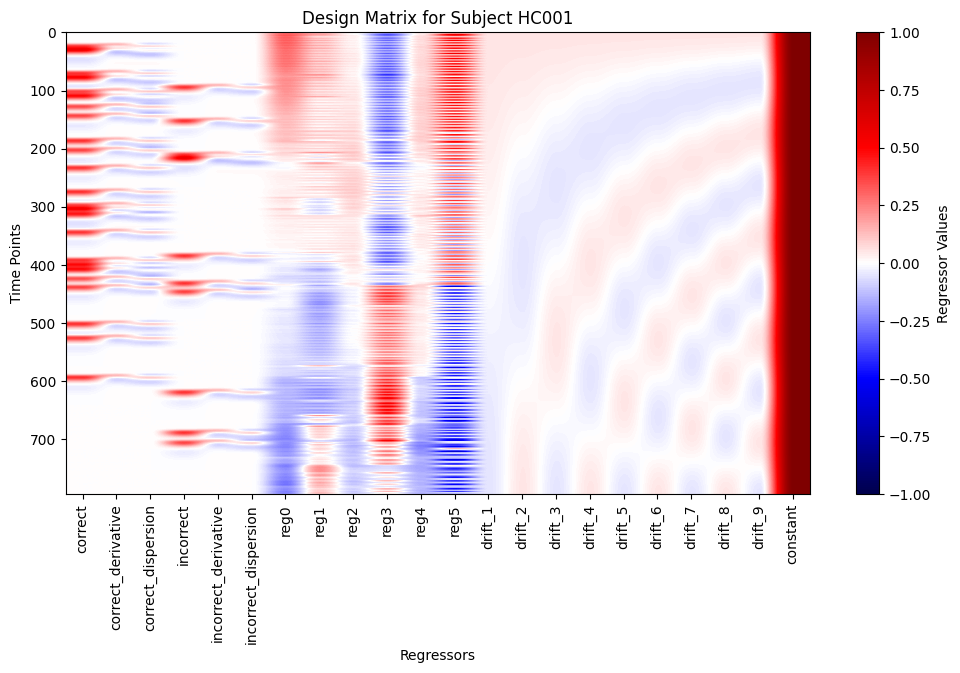

In [90]:
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

In [91]:
if not useCheckpoints:
    contrastnames_patternsep2=list(contrasts.keys())
    contrasts_epiencode = np.ones((nV, 2, len(subs), len(contrastnames_patternsep2))) * np.nan
    contrasts_epiencode_neo = np.ones((200, 2, len(subs), len(contrastnames_patternsep2))) * np.nan
    for s, sub in enumerate(subs):
        for h, hemi in enumerate(hemis):
            for l, label in enumerate(labels):
                for c, contrast_name in enumerate(contrastnames_patternsep2):                 
                    contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/encoding/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-encoding_contrast-{contrast_name}.shape.gii'
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_epiencode[:, h, s, c] = data
                    contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/encoding/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-encoding_contrast-{contrast_name}.shape.gii'
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_epiencode_neo[:,h, s, c] = data  # Corrected indexing
    np.savez_compressed("../checkpoints/MRI-3T-taskfMRI_betas-encoding", contrasts_epiretrieve, contrasts_epiencode_neo)

In [93]:
loaddat = np.load("../checkpoints/MRI-3T-taskfMRI_betas-encoding.npz", allow_pickle=True)
contrasts_epiencode = loaddat['arr_0']
contrasts_epiencode_neo = loaddat['arr_1']

## 3.2) Group-averaging and significance/consistency testing

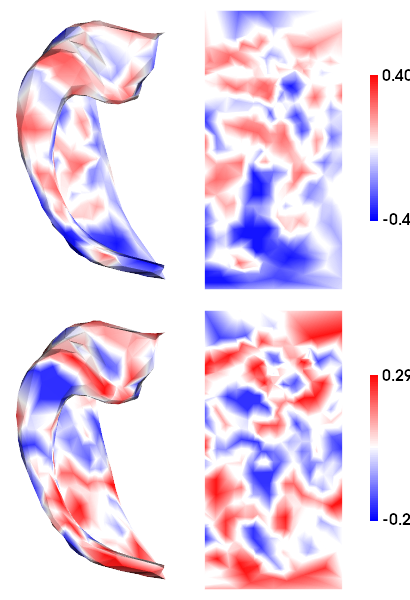

In [94]:
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_epiencode,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, cmap='bwr', color_range='sym', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

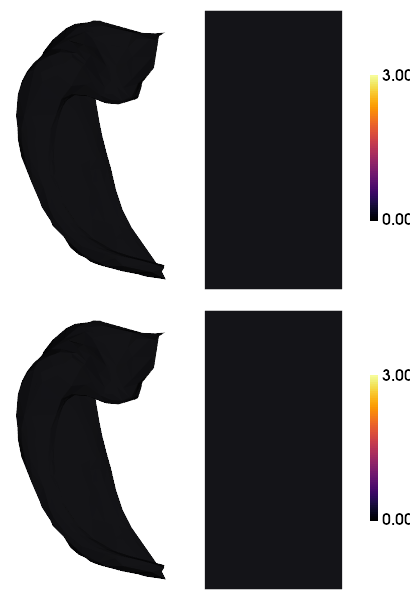

In [95]:
t = ttest_1samp(contrasts_epiencode.reshape((nV,2*len(subs),nContrasts)),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [96]:
#save the average maps
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for c,contrastname_epiencode in enumerate(list(contrasts.keys())):
            cdat = np.nanmean(contrasts_epiencode[iV[l],h,:,c],axis=1).flatten().astype(np.float32) 
            data_array = nib.gifti.GiftiDataArray(data=cdat.astype(np.float32))
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-epiencode_average-{len(subs)}-{hemi}_den-2mm_label-{label}_contrast-{contrastname_epiencode}.shape.gii')

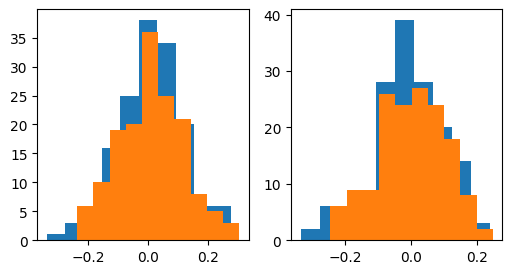

In [97]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,nContrasts))
fig, ax = plt.subplots(nrows=1, ncols=nContrasts, figsize=(3*nContrasts,3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(list(contrasts.keys())):
        cdat = contrasts_epiencode[:,h,:,f].reshape((nV,-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

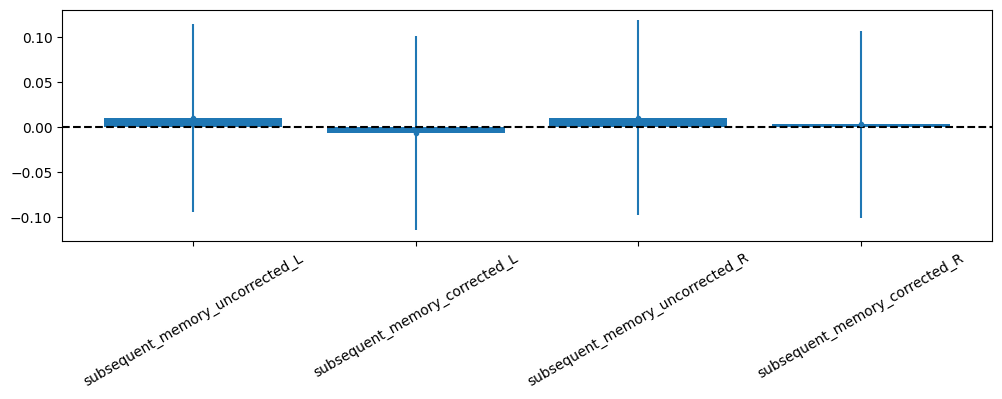

In [98]:
xnames = [s + "_L" for s in list(contrasts.keys())] + [s + "_R" for s in list(contrasts.keys())]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

## 3.3) Consider the neocortex

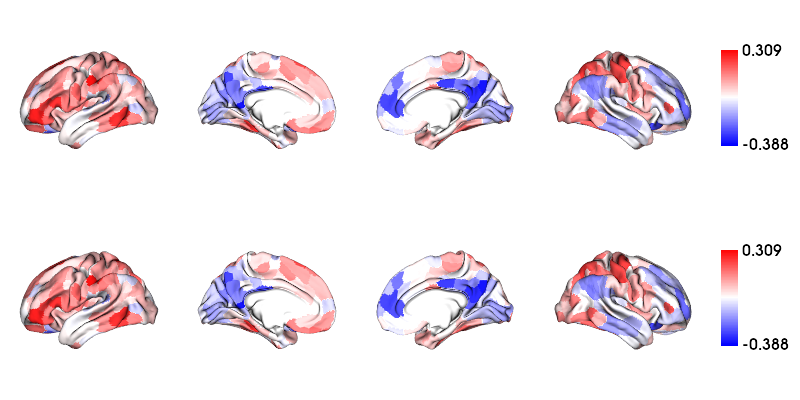

In [99]:
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points, nContrasts])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(nP):
        for c, contrast_name in enumerate(list(contrasts.keys())): 
            mc[parc==(i+1+(h*nP))] = np.nanmean(contrasts_epiencode_neo,axis=2)[i,h,c]
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,len(list(contrasts.keys()))), 
                 size=(800,200*len(list(contrasts.keys()))), color_bar=True, cmap='bwr', embed_nb=True,nan_color=(1, 1, 1, 1))

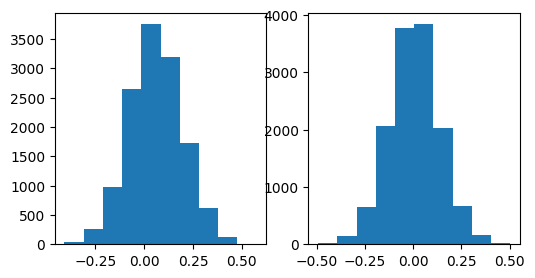

In [100]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,nContrasts))
fig, ax = plt.subplots(nrows=1, ncols=nContrasts, figsize=(3*nContrasts,3))
for f,feature in enumerate(list(contrasts.keys())):
    cdat = contrasts_epiencode_neo[:,:,:,f].reshape((nP,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

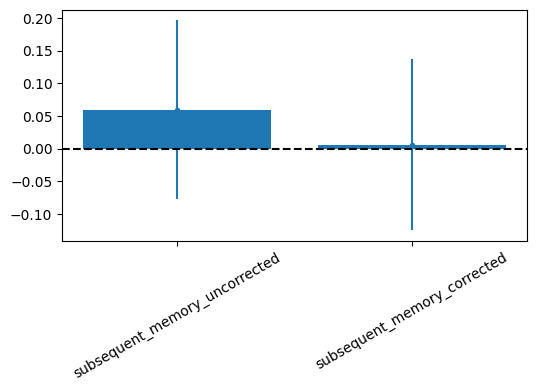

In [101]:
xnames = list(contrasts.keys())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*nContrasts,3))
plt.bar(range(len(list(contrasts.keys()))),mfcorr)
plt.errorbar(range(len(list(contrasts.keys()))),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(list(contrasts.keys()))),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

In [102]:
end_time = time.time()
duration = end_time - start_time
print(f"Total duration: {duration:.2f} seconds")
duration

Total duration: 82.16 seconds


82.16129183769226